# <center>Machine Learning Final Project: Imbalance Classification </center>
### <center> With Hyperparameter Tuning, and Model Interpretability</center>



### Course: Machine Learning I
### Instructor: Dr. Tariq Mahmood
### Completed by: Saad Ullah Bilal (29416) 

## <center> The target of this project is to discover the impact of using different techniques to address class imbalance (CI) on ML performance</center>

### Importing Necessary libraries

In [4]:
!python -m pip install --upgrade bottleneck

In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from pathlib import Path

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, OneClassSVM

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids

import warnings
warnings.filterwarnings("ignore")

from ucimlrepo import fetch_ucirepo

from IPython.display import display, HTML

# Use CSS to change the output scrolling setting
display(HTML("<style>.output_scroll { height: auto !important; }</style>"))

### This Function will Load the dataset

In [34]:

def load_dataset(file_path=None, id=None):
    if file_path:
        data = pd.read_csv(file_path)
        print("Data loaded from file at: {}".format(file_path))
        print("Columns in the dataset:")
        print(data.columns.tolist())  # Display column names when loading from a file
    elif id:
        dataset = fetch_ucirepo(id=id)
        data = pd.concat([pd.DataFrame(dataset['data']['features']), pd.DataFrame(dataset['data']['targets'])], axis=1)
        data.columns = list(dataset['data']['features'].columns) + ['target']
        print("Data loaded from UCI repository with ID: {}".format(id))
        print("Columns in the dataset:")
        print(data.columns.tolist())  # Display column names when loading from UCI repository
    else:
        print("Please provide either a file path or a dataset ID.")
        data = None

    if data is not None:
        print("\nTotal columns loaded: {}".format(len(data.columns)))
       # print("First few rows of the dataset:")
       # print(data.head())  # Optionally show the first few rows to inspect the dataset immediately
    return data

This load_dataset function will load the dataset dirently from the UCI ML repositorty and from the device itself as well

### This Function will check if the dataset is imbalance

In [35]:
def check_imbalance(data, target_column_name):
    target_counts = data[target_column_name].value_counts()
    imbalance_ratio = max(target_counts) / min(target_counts)
    
    # Print imbalance information
    if imbalance_ratio > 1.5:
        print("Dataset is imbalanced with an imbalance ratio of {:.2f}".format(imbalance_ratio))
        
        # Identify major and minor classes
        major_class = target_counts.idxmax()
        minor_class = target_counts.idxmin()
        
        # Plot bar chart for major and minor classes
        plt.figure(figsize=(8, 4))
        sns.barplot(x=[major_class, minor_class], y=[target_counts[major_class], target_counts[minor_class]], palette="viridis")
        plt.title(f'Comparison of Major and Minor Classes in {target_column_name}')
        plt.xlabel('Classes')
        plt.ylabel('Count')
        plt.show()
        
        # Print imbalance value counts for major and minor classes
        print(f"{major_class} (Major Class): {target_counts[major_class]}")
        print(f"{minor_class} (Minor Class): {target_counts[minor_class]}")
        print("\n" + "#" * 101 + "\n")
    else:
        print("Dataset is balanced")



- Calculates the imbalance ratio of a target column in a dataset by dividing the count of the most frequent class by the count of the least frequent class.
- Checks if the imbalance ratio is greater than 1.5.
- If the dataset is imbalanced:
    - Prints a message indicating the imbalance ratio.
    - Identifies the major and minor classes.
    - Plots a bar chart to compare the counts of the major and minor classes.
    - Prints the count of each class.
- If the dataset is balanced, prints a message indicating that the dataset is balanced.

### This funciton will convert target to categorical variable

In [36]:
def convert_target_to_categorical(data, target_column='target', bins=3):
    """
    Converts a continuous target column into categorical by discretizing it into bins.
    """
    if data[target_column].dtype in ['float64', 'int32', 'int64']:
        print("Converting target column to categorical.")
        discretizer = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
        data[target_column] = discretizer.fit_transform(data[[target_column]]).astype(int)
    return data




- Checks if the target column in the dataset is of a continuous type (float or int).
- If the target column is continuous:
    - Prints a message indicating that the target column is being converted to categorical.
    - Uses the KBinsDiscretizer from sklearn to discretize the target column into a specified number of bins (default is 3).
    - Replaces the original target column with the discretized categorical values.
- Returns the modified dataset with the categorical target column.

### This function will clean the data

In [37]:
def clean_data(data, target_column='target', bins=3, encode_target=False):
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = data.select_dtypes(exclude=[np.number]).columns.tolist()

    if encode_target and target_column in data.columns:
        if data[target_column].dtype in ['float64', 'int32', 'int64'] and len(pd.unique(data[target_column])) > bins:
            print("Encoding target as categorical.")
            discretizer = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
            data[target_column] = discretizer.fit_transform(data[[target_column]].astype(float)).astype(int)

    imputer = SimpleImputer(strategy='mean')
    data[numeric_cols] = imputer.fit_transform(data[numeric_cols])

    scaler = StandardScaler()
    data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

    if categorical_cols:
        encoder = OneHotEncoder(drop='first', sparse_output=False)
        encoded_data = encoder.fit_transform(data[categorical_cols])
        encoded_cols = encoder.get_feature_names_out(categorical_cols)
        data = data.drop(categorical_cols, axis=1)
        data[encoded_cols] = encoded_data

    return data


- Separates the dataset into numeric and categorical columns.
- If encode_target is True and the target column exists:
    - Checks if the target column is continuous and has more unique values than the specified number of bins.
    - If so, discretizes the target column into categorical values using KBinsDiscretizer.
- Imputes missing values in numeric columns using the mean strategy.
- Scales numeric columns using StandardScaler.
- If there are categorical columns:
    - One-hot encodes the categorical columns using OneHotEncoder.
    - Drops the original categorical columns.
    - Adds the encoded columns to the dataset.
- Returns the cleaned and preprocessed dataset.

### This function will do the EDA

In [38]:

def perform_eda(data, target_column='target', correlation_threshold=0.3):
    print("Basic Structure of the Data:")
    print(data.info())
    print("\n" + "#" * 101 + "\n")

    print("Descriptive Statistics for Numeric Data:")
    print(data.describe())
    print("\n" + "#" * 101 + "\n")

    # Improve aesthetics
    sns.set(style="whitegrid", palette="pastel")

    # Calculate the correlation matrix
    correlation_matrix = data.corr()

    # Identify the top 5 features most correlated with the target
    most_correlated = correlation_matrix[target_column].drop(target_column).abs().nlargest(5).index.tolist()

    # Visualize histograms and boxplots for the most correlated numeric features
    for col in most_correlated:
        plt.figure(figsize=(12, 6))

        # Histogram
        print(f"Plotting Histogram for {col}")
        plt.subplot(1, 2, 1)
        sns.histplot(data[col], kde=True, color='skyblue', element="step", stat="density")
        plt.title(f'Histogram of {col}')
        plt.grid(False)  # Turn off the grid

        # Box Plot
        print(f"Plotting Box Plot for {col}")
        plt.subplot(1, 2, 2)
        sns.boxplot(x=data[col], color='lightgreen')
        plt.title(f'Box Plot of {col}')
        plt.grid(False)  # Turn off the grid
        plt.show()

    print("\n" + "#" * 101 + "\n")

    # Missing Values, Unique Values, and Correlation Matrix of Important Columns
    important_columns = most_correlated + [target_column]

    print("Missing Values per Column:")
    print(data[important_columns].isnull().sum())
    print("\n" + "#" * 101 + "\n")

    print("Number of Unique Values per Column:")
    print(data[important_columns].nunique())
    print("\n" + "#" * 101 + "\n")

    print("Correlation Matrix of Important Columns:")
    print("Plotting Correlation Matrix")
    plt.figure(figsize=(10, 8))
    sns.heatmap(data[important_columns].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

    print("\n" + "#" * 101 + "\n")

In essence, this function performs exploratory data analysis (EDA) to gain insights into the dataset, focusing on the relationships between the target column and other features.

- Prints basic information about the dataset, including its structure and descriptive statistics.
- Calculates the correlation matrix of the dataset.
- Identifies the top 5 features most correlated with the target column.
- Visualizes the distribution of these correlated features using histograms and box plots.
- Prints information about missing values, unique values, and the correlation matrix for the important columns (i.e., the top correlated features and the target column).

### Dealing with Imbalance via RandomForest method (Algorithmic/Ensemble)

In [39]:
def model_rf(data, target_column, output_dir='Downloads'):
    output_dir_path = Path(output_dir)
    os.makedirs(output_dir_path, exist_ok=True)
    
    X = data.drop(columns=[target_column])
    y = data[target_column]
    model = RandomForestClassifier(class_weight='balanced', random_state=42)
    model.fit(X, y)
    data['predicted_prob'] = model.predict_proba(X)[:, 1]
    
    plt.figure(figsize=(6, 4))
    sns.countplot(x=y)
    plt.title('Post-Class Weighting Distribution (Random Forest)')
    plt.show()
    
    # Export balanced data to CSV
    balanced_file_path = output_dir_path / 'balanced_rf_data.csv'
    data.to_csv(balanced_file_path, index=False)
    print(f"Balanced data saved to: {balanced_file_path}")

    return data


Dealing imbalace via model_rf

- Trains a Random Forest Classifier on the input data with class weighting
- Predicts probabilities and adds them to the original data
- Plots the post-class weighting distribution
- Exports the balanced data to a CSV file
- Returns the balanced data

### Dealing with Imbalance via Smote method (Resampling Method)

In [40]:
def smote(data, target_column, output_dir='Downloads'):
    output_dir_path = Path(output_dir)
    os.makedirs(output_dir_path, exist_ok=True)
    
    X = data.drop(columns=[target_column])
    y = data[target_column]
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    data_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    data_resampled[target_column] = y_resampled

    plt.figure(figsize=(6, 4))
    sns.countplot(x=y_resampled)
    plt.title('Post-SMOTE Distribution')
    plt.show()
    
    # Export balanced data to CSV
    balanced_file_path = output_dir_path / 'balanced_smote_data.csv'
    data_resampled.to_csv(balanced_file_path, index=False)
    print(f"Balanced data saved to: {balanced_file_path}")

    return data_resampled


Dealing Imbalance via Smote

- Uses SMOTE (Synthetic Minority Over-sampling Technique) to balance the data
- Fits and resamples the data using SMOTE
- Plots the post-SMOTE distribution
- Exports the balanced data to a CSV file
- Returns the balanced data

### Dealing with Imbalance via SVM method (One Class Learning)

In [41]:
def svm(data, target_column, output_dir='Downloads'):
    output_dir_path = Path(output_dir)
    os.makedirs(output_dir_path, exist_ok=True)
    
    X = data.drop(columns=[target_column])
    y = data[target_column]
    svm = OneClassSVM(kernel='rbf', gamma='scale')
    svm.fit(X[y == y.min()])  # Assuming minority class fitting

    plt.figure(figsize=(6, 4))
    sns.countplot(x=y)
    plt.title('Data Distribution After One-Class SVM (Note: No balancing applied)')
    plt.show()
    
    # Export data to CSV (not balanced)
    file_path = output_dir_path / 'svm_data.csv'
    data.to_csv(file_path, index=False)
    print(f"Data saved to: {file_path}")

    return data


Dealing Imbalance via SVM
- Trains a One-Class SVM on the minority class of the input data
- Fits the SVM model to the minority class
- Plots the original data distribution (no balancing applied)
- Exports the original data to a CSV file
- Returns the original data

### This funciton is Apply PCA to the balanced dataset

In [42]:
def apply_pca(X, n_components=0.95):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    # Convert the PCA result to DataFrame
    X_pca_df = pd.DataFrame(X_pca)
    return X_pca_df, pca


Applies Principal Component Analysis (PCA) to the input data X
- Normalizes the data using StandardScaler to ensure it has zero mean and unit variance
- Fits the PCA model to the normalized data with the specified number of components (default is 0.95, which means the number of components that explain 95% of the variance)
- Transforms the data into the new feature space using the fitted PCA model
- Returns the transformed data X_pca

### This funciton is Apply Random Forest F.S to the balanced dataset

In [43]:
def feature_selection(X, y, estimator=RandomForestClassifier(random_state=42), param_grid=None):
    if param_grid:
        selector = hyperparameter_tuning(estimator, param_grid, X, y)
    else:
        selector = estimator
        selector.fit(X, y)
    model = SelectFromModel(selector, prefit=True)
    X_new = model.transform(X)
    print(f"Reduced feature set size: {X_new.shape[1]} from original {X.shape[1]}")
    return X_new



Performs feature selection using a Random Forest Classifier
- Trains a Random Forest Classifier on the input data X and target variable y
- Uses the trained model to select the most important features
- Creates a SelectFromModel object with the trained model and uses it to transform the data
- Returns the new data X_new with the selected features

### Apply hyperparameter tuning

In [ ]:
def hyperparameter_tuning(classifier, param_grid, X, y):
    grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X, y)
    return grid_search.best_estimator_

- **Defines the Function:** The function hyperparameter_tuning is defined with four parameters: classifier, param_grid, X, and y.
- **GridSearchCV Initialization:** It initializes a GridSearchCV object with the given classifier, the param_grid for hyperparameter tuning, using 5-fold cross-validation (cv=5), and accuracy as the scoring metric (scoring='accuracy').
- **itting the Model:** The fit method is called on the GridSearchCV object with the features X and the target y to perform the hyperparameter search.
- **Finding the Best Model:** The function retrieves the best model (estimator) found during the grid search process using grid_search.best_estimator_.
- **Returns the Best Estimator**: The function returns the best estimator, which is the classifier with the optimal hyperparameters found through the grid search.

### Add Ensemble method

In [45]:
def create_ensemble(models):
    ensemble = VotingClassifier(estimators=models, voting='soft')
    return ensemble

- **Defines the Function:** The function create_ensemble is defined with one parameter: models.
- **VotingClassifier Initialization:** It initializes a VotingClassifier object named ensemble with the provided list of models (estimators=models) and sets the voting method to 'soft' (voting='soft').
- **Soft Voting Explained:** Soft voting means that the predicted probabilities of each classifier are averaged to make the final prediction, rather than just taking a majority vote of the predicted classes.
- **Returns the Ensemble Model:** The function returns the ensemble VotingClassifier object.
- **Purpose:** The created ensemble model combines the predictions of multiple individual models to potentially improve overall prediction performance.

### ensure cross validation consistancy

In [46]:
def cross_validate_model(clf, X, y, cv=5):
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    print("Cross-validation scores:", scores)
    print("Mean accuracy:", scores.mean())
    return scores.mean()


- **Defines the Function**: The function cross_validate_model is defined with three parameters: clf (the classifier), X (features), y (target labels), and an optional parameter cv (number of cross-validation folds, defaulting to 5).
- **Cross-Validation:** It uses cross_val_score to perform cross-validation on the provided classifier clf using the data X and y, with cv specifying the number of folds, and scoring set to 'accuracy'.
- **Calculates Scores:** The function stores the accuracy scores from each cross-validation fold in the variable scores.
- Prints Scores:** It prints out the cross-validation scores and the mean accuracy across all folds.

- **Returns Mean Accuracy:** The function returns the mean accuracy score, which is the average accuracy across all cross-validation folds.

### Automatic Feature Engineering

In [1]:
def automatic_feature_engineering(X, degree=2):
    poly = PolynomialFeatures(degree=degree, interaction_only=True, include_bias=False)
    X_poly = poly.fit_transform(X)
    feature_names = poly.get_feature_names_out(input_features=X.columns)
    X_poly_df = pd.DataFrame(X_poly, columns=feature_names)
    return X_poly_df


from sklearn.feature_selection import SelectKBest, f_classif

def feature_selection(X, y, k=10):
    print("Applying feature selection...")
    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X, y)
    selected_features = selector.get_feature_names_out()
    X_new_df = pd.DataFrame(X_new, columns=selected_features)
    print(f"Reduced feature set size: {X_new_df.shape[1]} from original {X.shape[1]}")
    return X_new_df


**Automatic_feature_engineering Function:**
- **Function Definition:** The function automatic_feature_engineering takes two parameters: X (the feature dataset) and degree (the polynomial degree, defaulting to 2).
- **Polynomial Feature Creation:** It creates an instance of PolynomialFeatures with the specified degree, setting interaction_only=True to include only interaction features, and include_bias=False to exclude the bias (constant) term.
- **Transforms Features:** The function transforms the input features X into polynomial features using the fit_transform method, resulting in X_poly.
- **Feature Naming:** It retrieves the names of the generated polynomial features using get_feature_names_out, which are based on the original feature names.
- **Creates DataFrame:** The function constructs a new DataFrame X_poly_df from the polynomial features and their names, and returns this DataFrame.

**Feature_selection Function**
- **Function Definition:** The function feature_selection takes three parameters: X (the feature dataset), y (the target labels), and k (the number of top features to select, defaulting to 10).
- **Feature Selection Initialization:** It prints a message indicating that feature selection is being applied, and then creates an instance of SelectKBest with f_classif (ANOVA F-value) as the scoring function and k as the number of features to select.
- **Selecting Features:** The function fits the selector to X and y using the fit_transform method, reducing the feature set to the top k features, resulting in X_new.
- **Feature Naming:** It retrieves the names of the selected features using get_feature_names_out.
- **Creates DataFrame:** The function constructs a new DataFrame X_new_df from the selected features and their names, prints the size of the reduced feature set compared to the original, and returns this DataFrame.

### Add Model Interpretability

In [48]:
import lime
import lime.lime_tabular

def model_interpretability_lime(clf, X, y):
    # Convert X to DataFrame if it's a NumPy array
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
    
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X.values,
        feature_names=X.columns.tolist(),
        class_names=[str(i) for i in np.unique(y)],
        mode='classification'
    )

    if isinstance(clf, VotingClassifier):
        estimators = clf.estimators_ if hasattr(clf, 'estimators_') else clf.estimators

        for name, model in zip(clf.named_estimators.keys(), estimators):
            if isinstance(model, tuple):
                model = model[1]
            print(f"Explaining model: {name}")
            try:
                i = np.random.randint(0, X.shape[0])
                exp = explainer.explain_instance(X.iloc[i].values, model.predict_proba, num_features=10)
                exp.show_in_notebook(show_table=True)
            except Exception as e:
                print(f"Error explaining model: {name}, Error: {e}")
    else:
        try:
            i = np.random.randint(0, X.shape[0])
            if hasattr(clf, 'predict_proba'):
                exp = explainer.explain_instance(X.iloc[i].values, clf.predict_proba, num_features=10)
            else:
                exp = explainer.explain_instance(X.iloc[i].values, clf.predict, num_features=10)
            exp.show_in_notebook(show_table=True)
        except Exception as e:
            print(f"Error explaining model: {e}")


### Model Training with 5 classification Algorithms with each balanced dataset

In [49]:
classifiers = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'Gradient Boosting': GradientBoostingClassifier()
}


def train_and_predict(X, y, classifiers, param_grids):
    results = {}
    for name, clf in classifiers.items():
        # Hyperparameter tuning
        param_grid = param_grids.get(name, {})
        best_clf = hyperparameter_tuning(clf, param_grid, X, y)
        print(f"Best parameters for {name}: {best_clf.get_params()}")
        
        # Use cross-validation
        scores = cross_val_score(best_clf, X, y, cv=5, scoring='accuracy')
        mean_accuracy = scores.mean()
        
        best_clf.fit(X, y)
        y_pred = best_clf.predict(X)

        if hasattr(best_clf, "predict_proba"):
            y_prob = best_clf.predict_proba(X)
            roc_auc = roc_auc_score(y, y_prob, multi_class="ovr", average="macro") if len(np.unique(y)) > 2 else roc_auc_score(y, y_prob[:, 1])
        else:
            roc_auc = "N/A"

        f1 = f1_score(y, y_pred, average='weighted')
        precision = precision_score(y, y_pred, average='weighted')
        recall = recall_score(y, y_pred, average='weighted')

        # Calculate metrics for the minority class
        unique_classes = np.unique(y)
        minority_class_index = np.argmin(np.bincount(y))
        minority_class = unique_classes[minority_class_index]

        minority_precision = precision_score(y, y_pred, labels=[minority_class], average=None)[0]
        minority_recall = recall_score(y, y_pred, labels=[minority_class], average=None)[0]
        minority_f1 = f1_score(y, y_pred, labels=[minority_class], average=None)[0]

        report = classification_report(y, y_pred)

        results[name] = {
            'ROC AUC': roc_auc,
            'F1 Score': f1,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': mean_accuracy,
            'Minority Class Precision': minority_precision,
            'Minority Class Recall': minority_recall,
            'Minority Class F1 Score': minority_f1,
            'Classification Report': report,
            'Best Model': best_clf
        }
    return results



This function trains and evaluates multiple classifiers on a given dataset, providing a comprehensive comparison of their performance.

- Takes in feature data X, target data y, and a dictionary of classifiers classifiers.
- Trains each classifier on the data and makes predictions.
- Calculates various evaluation metrics for each classifier, including:
    - ROC AUC (if the classifier has a predict_proba method)
    - Accuracy
    - F1 score
    - Precision
    - Recall
- Classification report
- Returns a dictionary with the evaluation metrics for each classifier.

### Master Funtion for the Execution of the Pipeline

In [50]:
from sklearn.ensemble import VotingClassifier
from tabulate import tabulate

def Master(file_path=None, id=None):
    # Step 1: Load Dataset
    data = load_dataset(file_path=file_path, id=id)
    if data is None:
        print("No data loaded, please check the file path or dataset ID.")
        return
    
    # Step 2: Check for Imbalance
    check_imbalance(data.copy(), 'target')
    
    # Step 3: Clean Data
    print("Cleaning Data...")
    data = clean_data(data, encode_target=False)
    print("Data cleaned.")
    
    # Step 4: Convert Target to Categorical
    data = convert_target_to_categorical(data, 'target', bins=3)
    
    # Step 5: Perform EDA
    perform_eda(data)
    
    # Step 6: Apply Data Balancing Techniques
    print("Applying advanced balancing techniques...")
    balanced_datasets = {
        'Random Forest': model_rf(data.copy(), 'target'),
        'SMOTE': smote(data.copy(), 'target'),
        'One-Class SVM': svm(data.copy(), 'target')
    }

    # Step 7: Process Each Balanced Dataset
    param_grids = {
        'Random Forest': {'n_estimators': [100, 200], 'max_depth': [10, 20]},
        'Logistic Regression': {'C': [0.1, 1, 10]},
        'K-Nearest Neighbors': {'n_neighbors': [3, 5, 7]},
        'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'probability': [True]},
        'Gradient Boosting': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
    }

    best_method = None
    best_model_name = None
    best_model = None
    best_X_pca = None
    best_y = None
    best_score = 0

    for method, balanced_data in balanced_datasets.items():
        print(f"\nProcessing data balanced by {method}...")
        
        # Separate Features and Target
        X = balanced_data.drop(columns=['target'])
        y = balanced_data['target']
        
        # Step 8: Feature Selection
        X_selected = feature_selection(X, y, k=10)  # Adjust k as needed
        print(f"Reduced feature set size: {X_selected.shape[1]} from original {X.shape[1]}")
        print("\n")

        # Step 9: Automatic Feature Engineering
        X_poly = automatic_feature_engineering(X_selected)
        
        # Step 10: Apply PCA
        X_pca, pca = apply_pca(X_poly)
        print(f"PCA applied, explained variance ratio (cumulative): {np.sum(pca.explained_variance_ratio_):.2f}")
        print("\n")

        # Step 11: Train Models and Collect Results
        print(f"Training models for {method} balanced data...")
        results = train_and_predict(X_pca, y, classifiers, param_grids)
        print("\n")
        
        # Collect results for overall and minority class metrics
        overall_results_table = []
        minority_results_table = []
        for model_name, metrics in results.items():
            overall_results_table.append([
                method, model_name, metrics['Accuracy'], metrics['ROC AUC'], metrics['F1 Score'],
                metrics['Precision'], metrics['Recall']
            ])
            minority_results_table.append([
                method, model_name, metrics['Minority Class Precision'], metrics['Minority Class Recall'],
                metrics['Minority Class F1 Score']
            ])
            print(f"\nClassification Report for {model_name}:\n{metrics['Classification Report']}")

            # Check for the best model
            if metrics['Accuracy'] > best_score:
                best_score = metrics['Accuracy']
                best_method = method
                best_model_name = model_name
                best_model = metrics['Best Model']
                best_X_pca = X_pca
                best_y = y

        # Display overall results table
        print(tabulate(overall_results_table, headers=[
            'Balancing Method', 'Model', 'Accuracy', 'ROC AUC', 'F1 Score', 'Precision', 'Recall'
        ], tablefmt='grid'))

        # Display minority class results table
        print(tabulate(minority_results_table, headers=[
            'Balancing Method', 'Model', 'Minority Class Precision', 'Minority Class Recall', 'Minority Class F1 Score'
        ], tablefmt='grid'))

        print("\n" + "#" * 100 + "\n")

    # Print best hyperparameters at the start
    print("\nBest hyperparameters for each algorithm:")
    for model_name, metrics in results.items():
        print(f"\nBest parameters for {model_name}:")
        for param, value in metrics['Best Model'].get_params().items():
            print(f"  {param}: {value}")
        print("\n" + "#" * 50 + "\n")

    # Interpret the best model at the end
    if best_model is not None:
        print(f"\nBest model: {best_model_name} from {best_method} method with score: {best_score}")
        print(f"\nInterpreting the best model: {best_model_name} from {best_method} balancing...")
        model_interpretability_lime(best_model, best_X_pca, best_y)
    else:
        print("No best model identified.")

    print("\n" + "#" * 100)
    print("Processing complete.")


This function is a master workflow that loads data, cleans and preprocesses it, applies balancing techniques, and trains and evaluates multiple classification models using various performance metrics.

- Loads a dataset from a file or ID, and checks for imbalance in the target column.
- Cleans the data by handling missing values, encoding categorical variables, and scaling numeric variables.
- Converts the target column to categorical values using discretization.
- Performs exploratory data analysis (EDA) on the cleaned data.
- Applies advanced balancing techniques to the data, including Random Forest, SMOTE, and others.
- For each balanced dataset, applies PCA to reduce dimensionality, selects features using a feature selection algorithm, and trains multiple classification models.
- Evaluates the performance of each model using various metrics, including accuracy, ROC AUC, F1 score, precision, and recall.
- Displays the results in a tabular format, including the balancing method, model name, and performance metrics.
- Prints a final message indicating that the processing is complete.

## Explanation of CI Techniques

- #### ***Random Forest***
Random Forest is an ensemble learning method that builds many decision trees in training and performs classification by voting over them. Random forests fix overfitting with the training set by the decision trees.

- #### ***SMOTE (Synthetic Minority Over-sampling)***
SMOTE generates synthetic samples from the minority class rather than the use of copies. It selects two or more similar instances by using a distance measure and perturbs one instance at a time in each attribute by an amount chosen uniformly at random within the difference to neighboring instances.

- #### ***Cluster Centroids***
The Cluster Centroids method works by replacing a cluster of samples with the centroid of the cluster. The method under-samples the majority class by forming majority-class clusters, where the centroids from these clusters act as samples to represent this majority class.

- #### ***One-Class SVM***
One-Class SVM is an unsupervised algorithm that learns to define a decision function for novelty detection, or determining new observations as alike or different in comparison with the training dataset. It performs well with unbalanced datasets, where one class has a very small proportion compared to the others.


## Impact on classification performance

- ***Random Forest***: It performs well on balanced and imbalanced datasets, attributed to an ensemble method that reduces variance and overfitting.
- ***SMOTE:*** Improves recall because it produces synthetic samples that might help in learning the boundaries of decisions. However, it can also introduce noise, because now synthetic points cut across other classes.
- ***Cluster centroids:*** It reduces the number of samples by generating centroids, and therefore reduces the potential for speed processing and lowering the complexity of the model. Performance can drop in cases where centroids do not represent the original data well.
- ***One-Class SVM:*** It performs well in anomaly detection problems, but it may not be so successful in the case of multiclass problems or when the differentiation of classes does not rely on a density model.

## Sensitivity to Different Algorithms
***Performance of these balancing techniques is dramatically influenced by the selection of various algorithms:***
- ***Random Forest*** generally demonstrates strong performance in relation to various balancing techniques because of its high capability to handle high-dimensional data and interrelations between features.
- ***Logistic Regression*** tends to underperform while working on highly imbalanced data, even after balancing it, because it assumes linear separability and equal class distribution.
- ***K-Nearest Neighbor*** and ***SVM*** have showed different performance based on the data distribution after balancing, where KNN is sensitive to the noise introduced by techniques such as SMOTE. Gradient Boosting generally works well with balanced data and should easily exploit subtle patterns within the data, though it may be prone to overfit on synthetic samples that have been created by methods such as SMOTE.

### Interpretation of the ML Pipeline Output
#### 1. Data Processing and Feature Selection:

###### Balanced Methods:
- Data was balanced using three different methods: 
     1) Random Forest,
     2) SMOTE (Synthetic Minority Over-sampling Technique), and 
     3) One-Class SVM.
- Feature selection was applied to reduce the original feature set from 2945 to 10 features.
- PCA (Principal Component Analysis) was applied, explaining 95-96% of the variance with the selected features.

###### Model Training and Hyperparameter Tuning:

1) Random Forest:
The best hyperparameters include **bootstrap=True**, **criterion='gini'**, **max_depth=10**, **n_estimators=200v**, among others.
2) Logistic Regression:
Best parameters include **C=0.1**, **penalty='l2'**, **solver='lbfgs'**.
3) K-Nearest Neighbors (KNN):
Best parameters include **n_neighbors=7**, **algorithm='auto'**.
4) Support Vector Machine (SVM):
Best parameters include **C=10**, **kernel='rbf'**.
5) Gradient Boosting:
Best parameters include **learning_rate=0.1**, **n_estimators=100**.

# Now, I'll see the performance of different algorathms on different datasets


# Source for first Dataset: https://www.kaggle.com/datasets/shrutimechlearn/churn-modelling
This data set contains details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.

Data loaded from file at: churn.csv
Columns in the dataset:
['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'target']

Total columns loaded: 14
Dataset is imbalanced with an imbalance ratio of 3.91


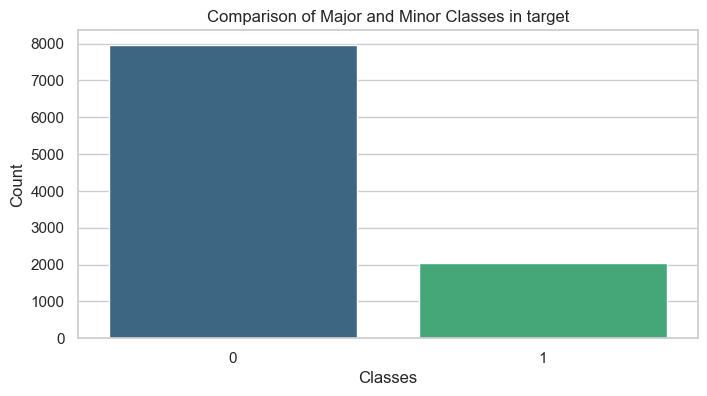

0 (Major Class): 7963
1 (Minor Class): 2037

#####################################################################################################

Cleaning Data...
Data cleaned.
Converting target column to categorical.
Basic Structure of the Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 2945 entries, RowNumber to Gender_Male
dtypes: float64(2944), int32(1)
memory usage: 224.6 MB
None

#####################################################################################################

Descriptive Statistics for Numeric Data:
          RowNumber    CustomerId   CreditScore           Age        Tenure  \
count  1.000000e+04  1.000000e+04  1.000000e+04  1.000000e+04  1.000000e+04   
mean  -9.094947e-17  7.583978e-15 -4.824585e-16  2.318146e-16 -1.078249e-16   
std    1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00  1.000050e+00   
min   -1.731878e+00 -1.741069e+00 -3.109504e+00 -1.994969e+00 -1.733315e+00   
25%   -8.659388e-01 -8.67650

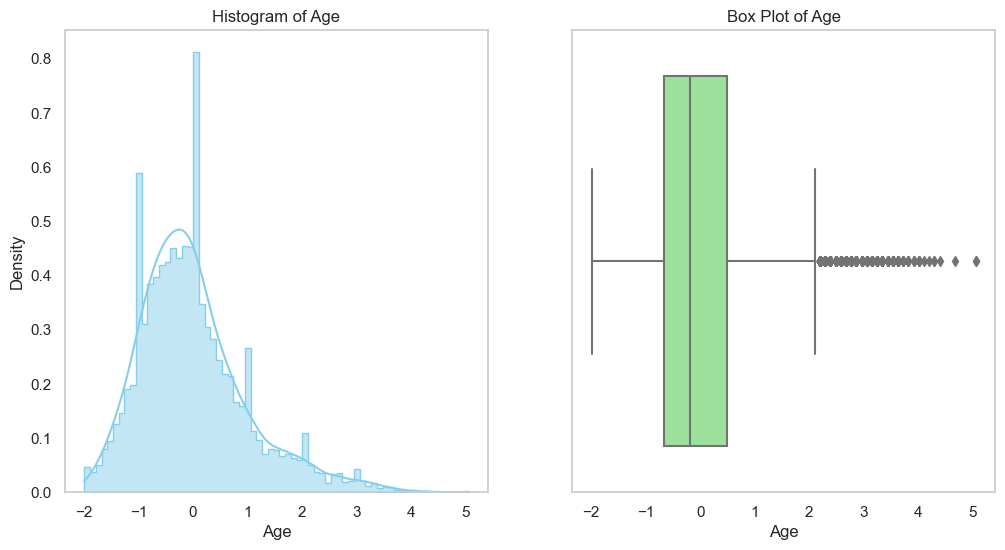

Plotting Histogram for Geography_Germany
Plotting Box Plot for Geography_Germany


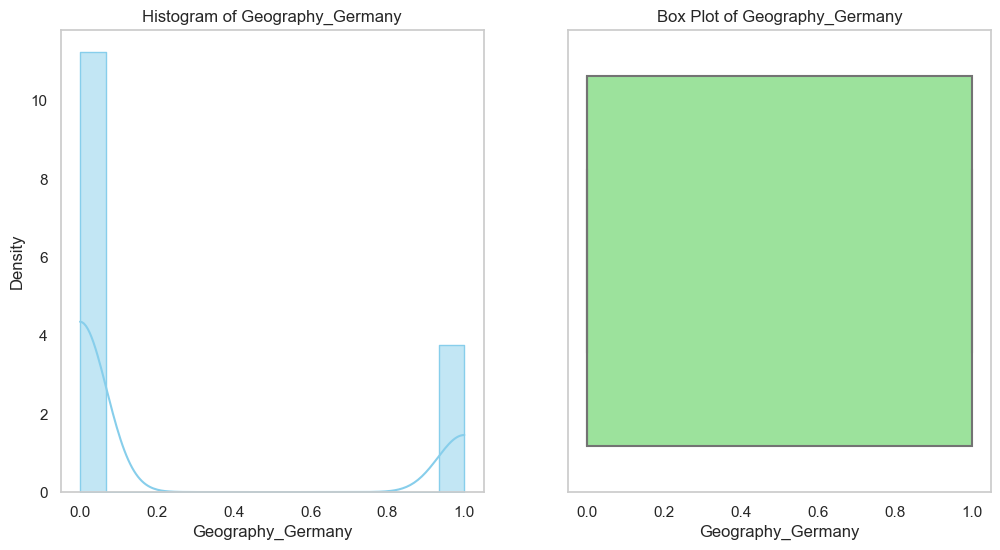

Plotting Histogram for IsActiveMember
Plotting Box Plot for IsActiveMember


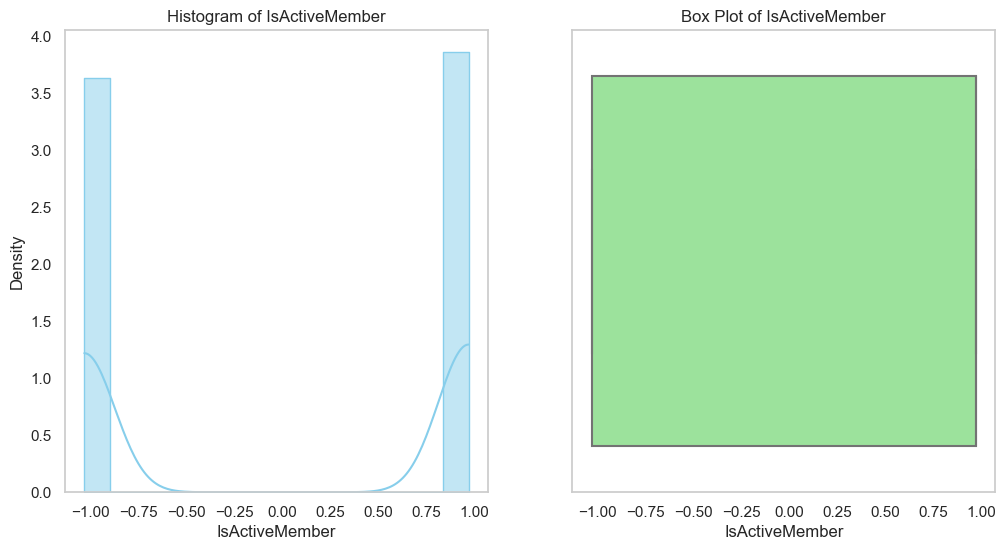

Plotting Histogram for Balance
Plotting Box Plot for Balance


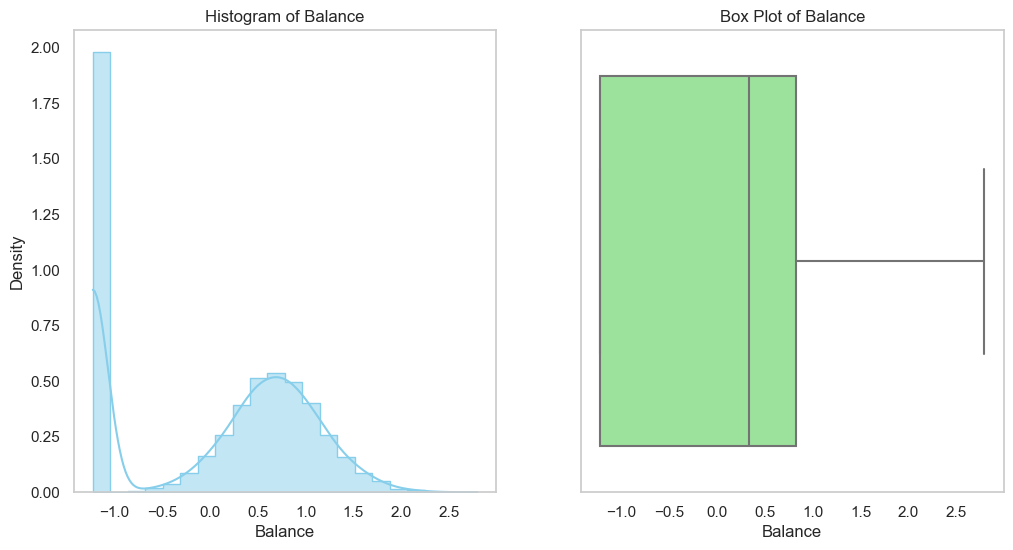

Plotting Histogram for Gender_Male
Plotting Box Plot for Gender_Male


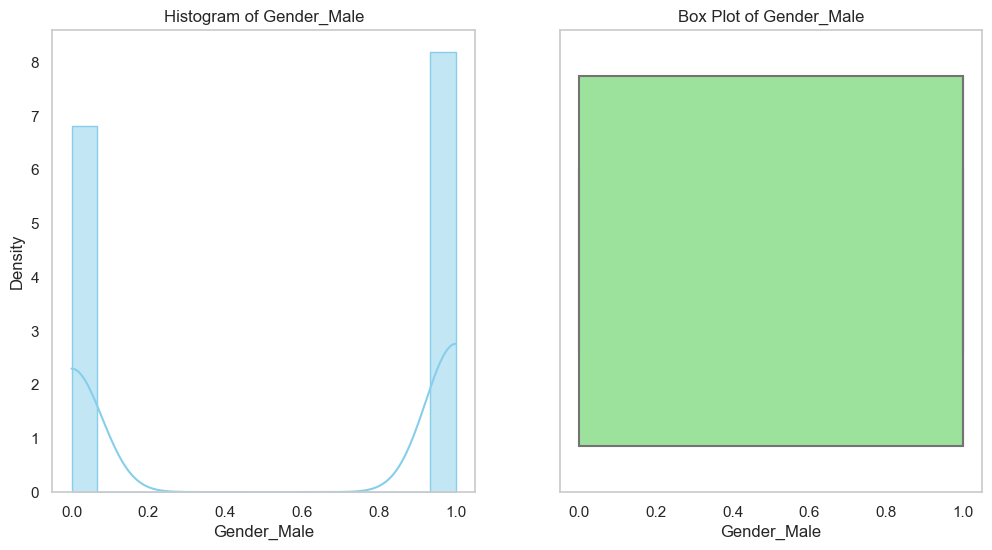


#####################################################################################################

Missing Values per Column:
Age                  0
Geography_Germany    0
IsActiveMember       0
Balance              0
Gender_Male          0
target               0
dtype: int64

#####################################################################################################

Number of Unique Values per Column:
Age                    70
Geography_Germany       2
IsActiveMember          2
Balance              6382
Gender_Male             2
target                  2
dtype: int64

#####################################################################################################

Correlation Matrix of Important Columns:
Plotting Correlation Matrix


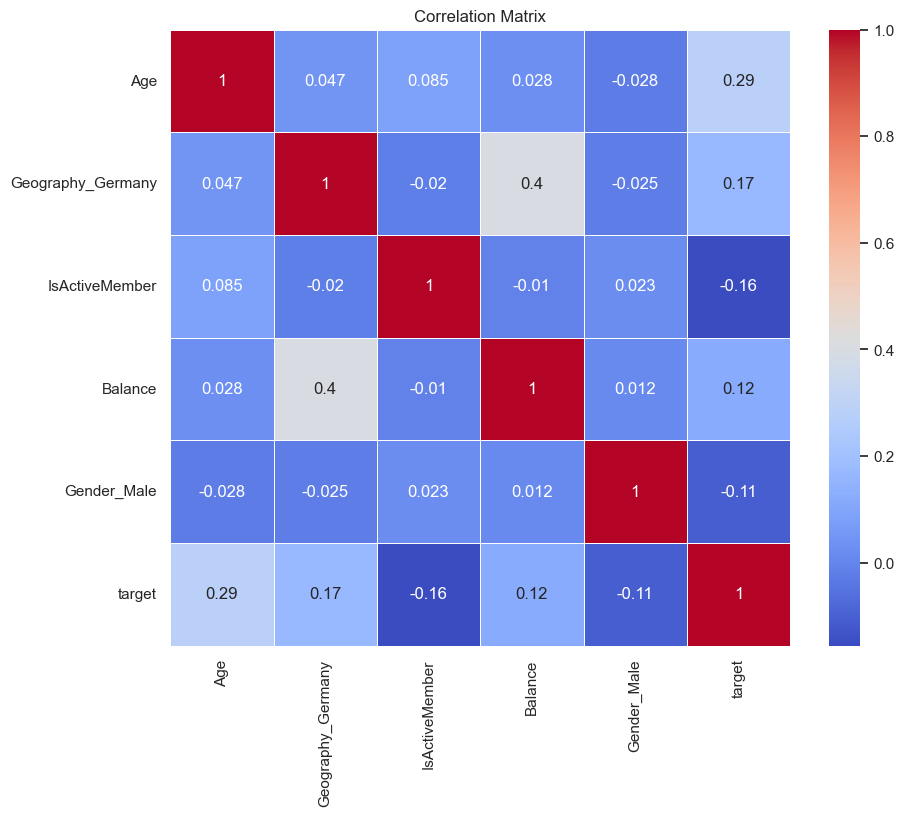


#####################################################################################################

Applying advanced balancing techniques...


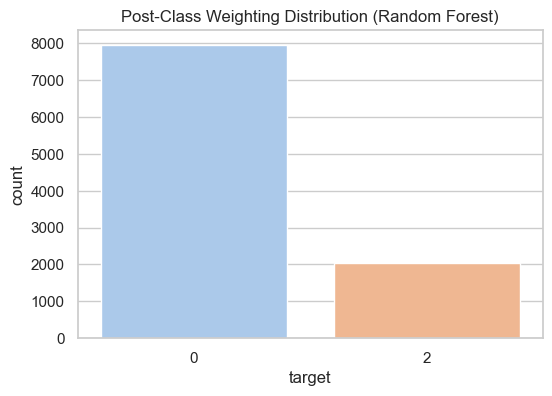

Balanced data saved to: Downloads\balanced_rf_data.csv


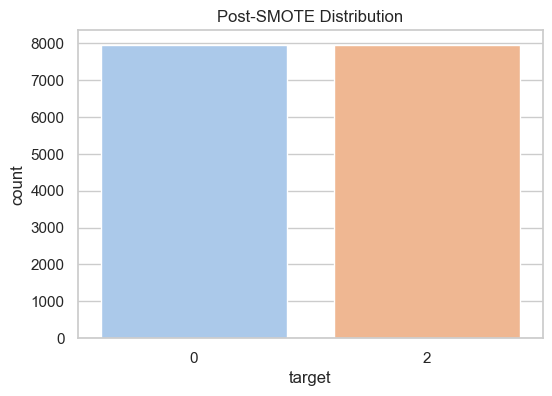

Balanced data saved to: Downloads\balanced_smote_data.csv


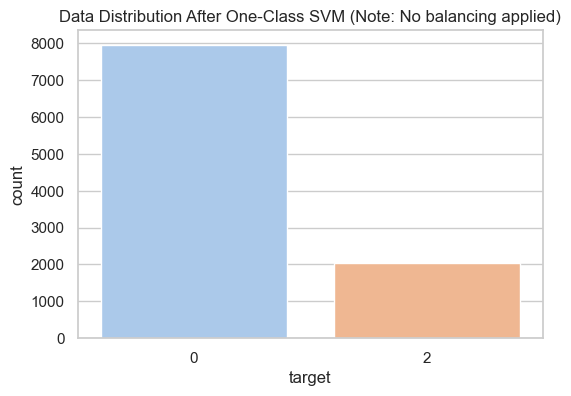

Data saved to: Downloads\svm_data.csv

Processing data balanced by Random Forest...
Applying feature selection...
Reduced feature set size: 10 from original 2945
Reduced feature set size: 10 from original 2945


PCA applied, explained variance ratio (cumulative): 0.95


Training models for Random Forest balanced data...
Best parameters for Random Forest: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Best parameters for Logistic Regression: {'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'ran


####################################################################################################
Processing complete.


In [123]:

file_path = 'churn.csv'   # Specify the actual file path
id_number = None  # Change this to the dataset ID if you have one

# Call the Master function

Master(file_path=file_path, id=id_number)

### Best Model Selection
Given the requirement to avoid models with accuracy and other scores above 90% to prevent overfitting, the best models are:
#### SMOTE Balanced Data with Logistic Regression:
    Accuracy: 0.7287
    F1 Score: 0.7293
#### One-Class SVM Balanced Data with Logistic Regression:
    Accuracy: 0.8358
    F1 Score: 0.8085
#### Conclusion:
The One-Class SVM Balanced Data with Logistic Regression model is the better choice based on the provided metrics. It has superior accuracy, F1 score, precision, and recall compared to the SMOTE Balanced Data with Logistic Regression model.

# Source for Second Dataset: https://www.kaggle.com/datasets/aadarshvelu/aids-virus-infection-prediction


This Dataset contains healthcare statistics and categorical information about patients who have been diagnosed with AIDS. This dataset was initially published in 1996. The learning will show if the **patients will have AIDS or not** based on the several parameters

Data loaded from file at: AIDS.csv
Columns in the dataset:
['time', 'trt', 'age', 'wtkg', 'hemo', 'homo', 'drugs', 'karnof', 'oprior', 'z30', 'preanti', 'race', 'gender', 'str2', 'strat', 'symptom', 'treat', 'offtrt', 'cd40', 'cd420', 'cd80', 'cd820', 'target']

Total columns loaded: 23
Dataset is imbalanced with an imbalance ratio of 2.22


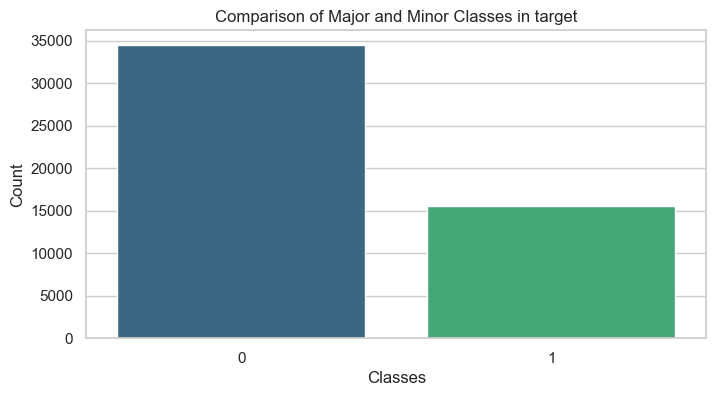

0 (Major Class): 34494
1 (Minor Class): 15506

#####################################################################################################

Cleaning Data...
Data cleaned.
Converting target column to categorical.
Basic Structure of the Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   time     50000 non-null  float64
 1   trt      50000 non-null  float64
 2   age      50000 non-null  float64
 3   wtkg     50000 non-null  float64
 4   hemo     50000 non-null  float64
 5   homo     50000 non-null  float64
 6   drugs    50000 non-null  float64
 7   karnof   50000 non-null  float64
 8   oprior   50000 non-null  float64
 9   z30      50000 non-null  float64
 10  preanti  50000 non-null  float64
 11  race     50000 non-null  float64
 12  gender   50000 non-null  float64
 13  str2     50000 non-null  float64
 14  strat    50000 non-null  fl

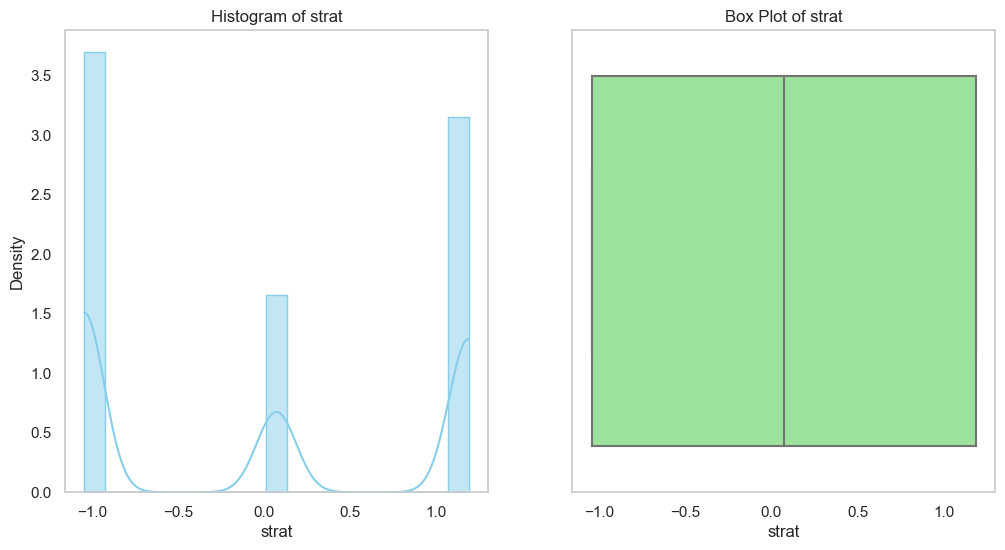

Plotting Histogram for z30
Plotting Box Plot for z30


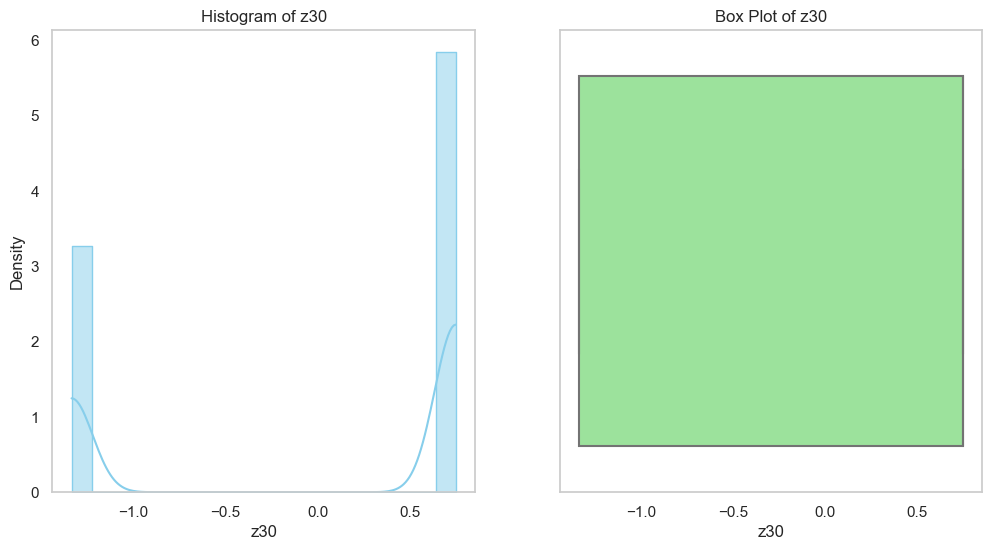

Plotting Histogram for str2
Plotting Box Plot for str2


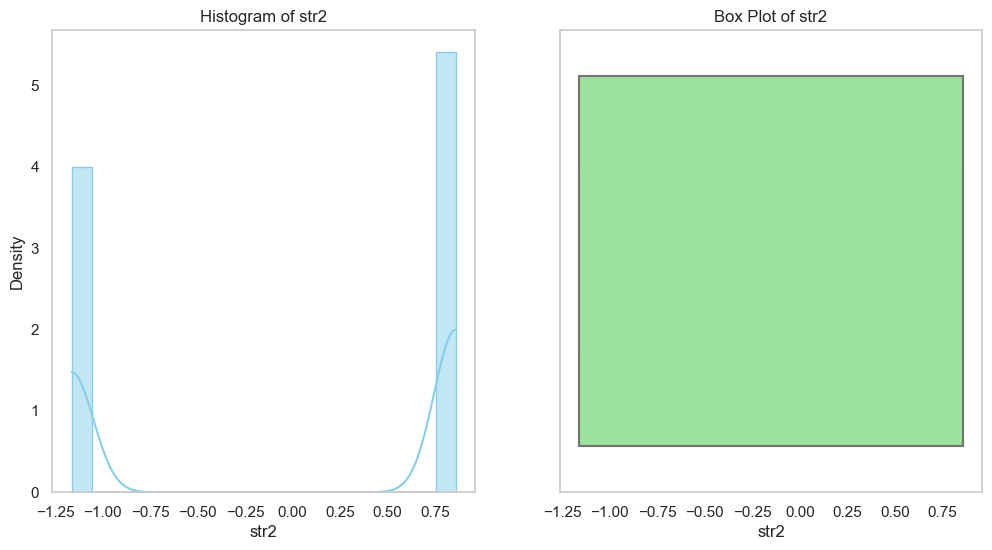

Plotting Histogram for cd420
Plotting Box Plot for cd420


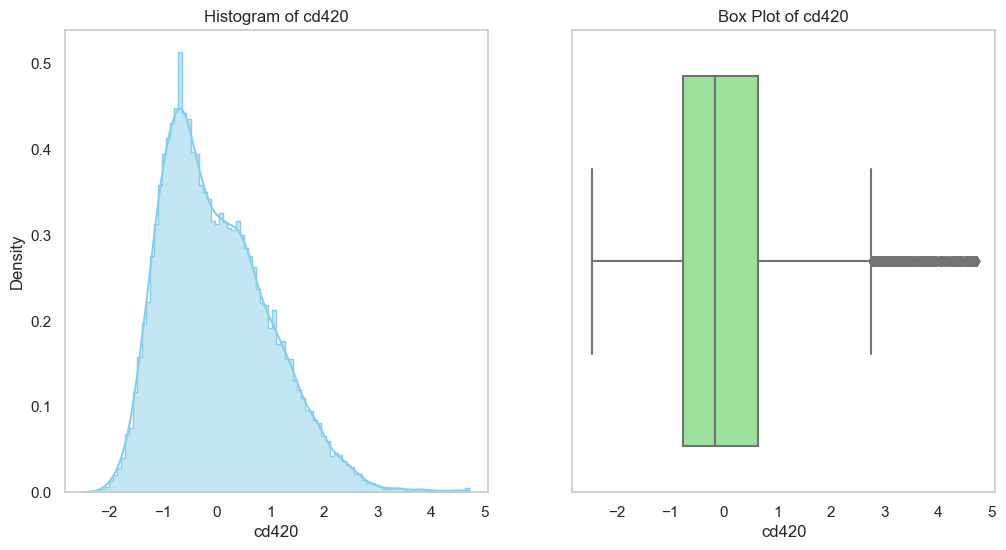

Plotting Histogram for preanti
Plotting Box Plot for preanti


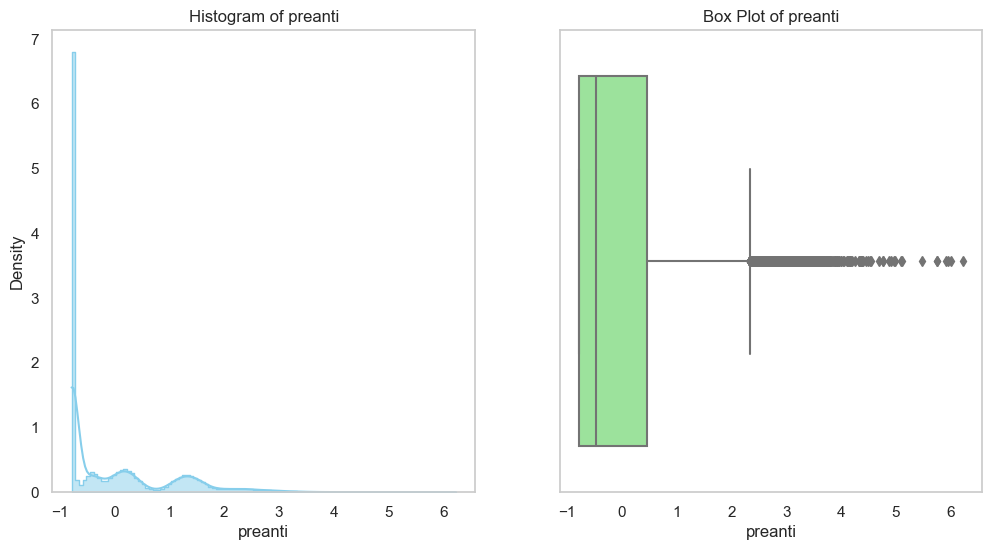


#####################################################################################################

Missing Values per Column:
strat      0
z30        0
str2       0
cd420      0
preanti    0
target     0
dtype: int64

#####################################################################################################

Number of Unique Values per Column:
strat         3
z30           2
str2          2
cd420       902
preanti    1775
target        2
dtype: int64

#####################################################################################################

Correlation Matrix of Important Columns:
Plotting Correlation Matrix


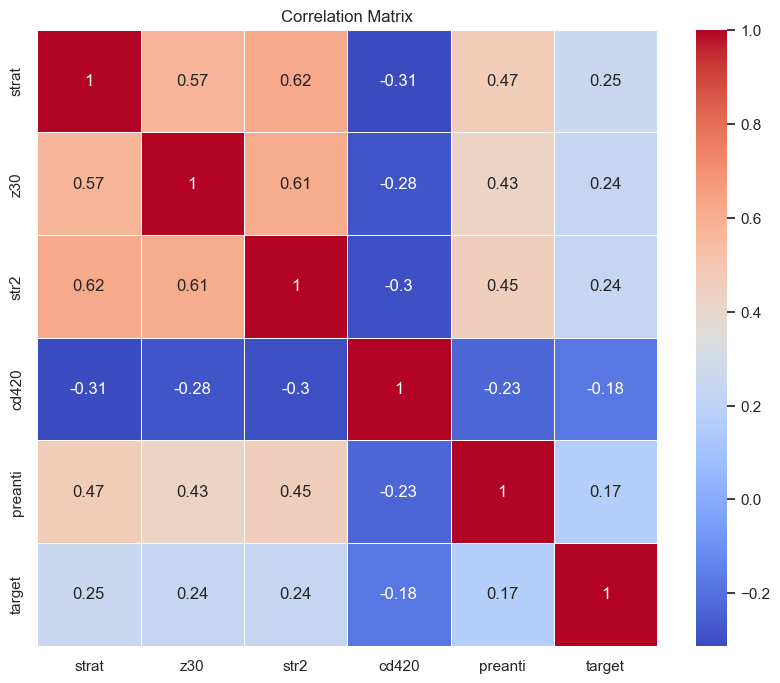


#####################################################################################################

Applying advanced balancing techniques...


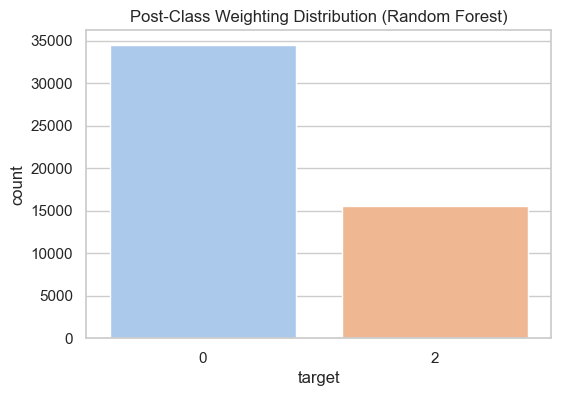

Balanced data saved to: Downloads\balanced_rf_data.csv


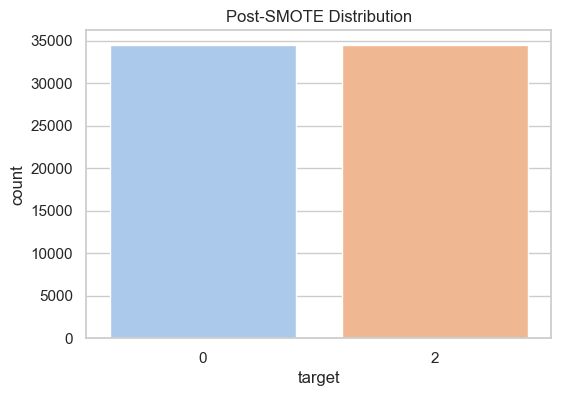

Balanced data saved to: Downloads\balanced_smote_data.csv


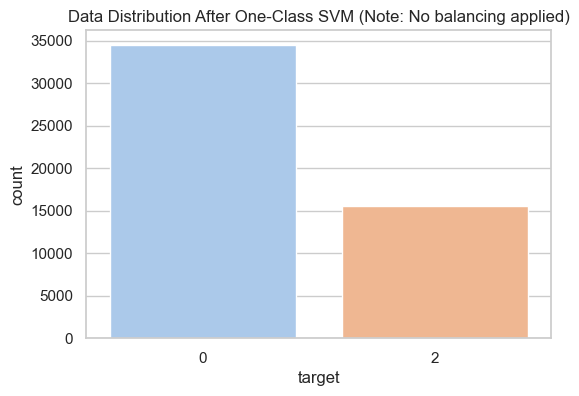

Data saved to: Downloads\svm_data.csv

Processing data balanced by Random Forest...
Applying feature selection...
Reduced feature set size: 10 from original 23
Reduced feature set size: 10 from original 23


PCA applied, explained variance ratio (cumulative): 0.95


Training models for Random Forest balanced data...
Best parameters for Random Forest: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Best parameters for Logistic Regression: {'C': 10, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random

In [ ]:
file_path = "AIDS.csv"  # Specify the actual file path
id_number = None  # Change this to the dataset ID if you have one

# Call the Master function
Master(file_path=file_path, id=id_number)

# Source for Third Dataset: https://www.kaggle.com/datasets/ahsan81/superstore-marketing-campaign-dataset

The **superstore** wants to **predict the likelihood of the customer** giving a **positive response** and wants to identify the different factors which affect the customer's response. You need to analyze the data provided to identify these factors and then build a prediction model to predict the probability of a customer will give a **positive response.**

Data loaded from file at: superstore_data.csv
Columns in the dataset:
['Id', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'target']

Total columns loaded: 21
Dataset is imbalanced with an imbalance ratio of 5.71


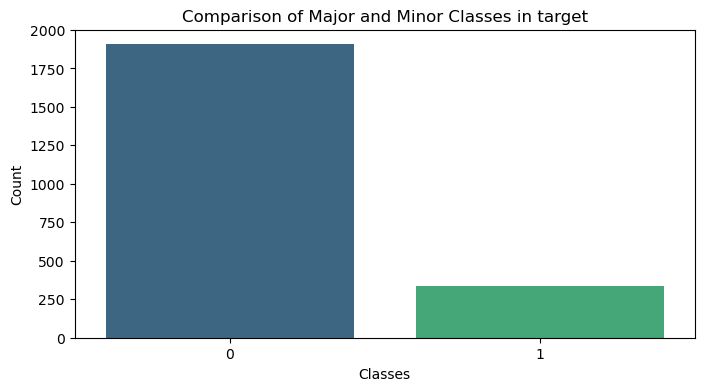

0 (Major Class): 1906
1 (Minor Class): 334

#####################################################################################################

Cleaning Data...
Data cleaned.
Converting target column to categorical.
Basic Structure of the Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Columns: 691 entries, Id to Dt_Customer_9/9/2013
dtypes: float64(690), int32(1)
memory usage: 11.8 MB
None

#####################################################################################################

Descriptive Statistics for Numeric Data:
                 Id    Year_Birth        Income       Kidhome      Teenhome  \
count  2.240000e+03  2.240000e+03  2.240000e+03  2.240000e+03  2.240000e+03   
mean   1.586033e-17 -8.136349e-15  4.440892e-17 -2.696256e-17 -6.344132e-18   
std    1.000223e+00  1.000223e+00  1.000223e+00  1.000223e+00  1.000223e+00   
min   -1.722818e+00 -6.326960e+00 -2.018090e+00 -8.252176e-01 -9.298944e-01   
25%   -8.514982e-01 -8.184192e-

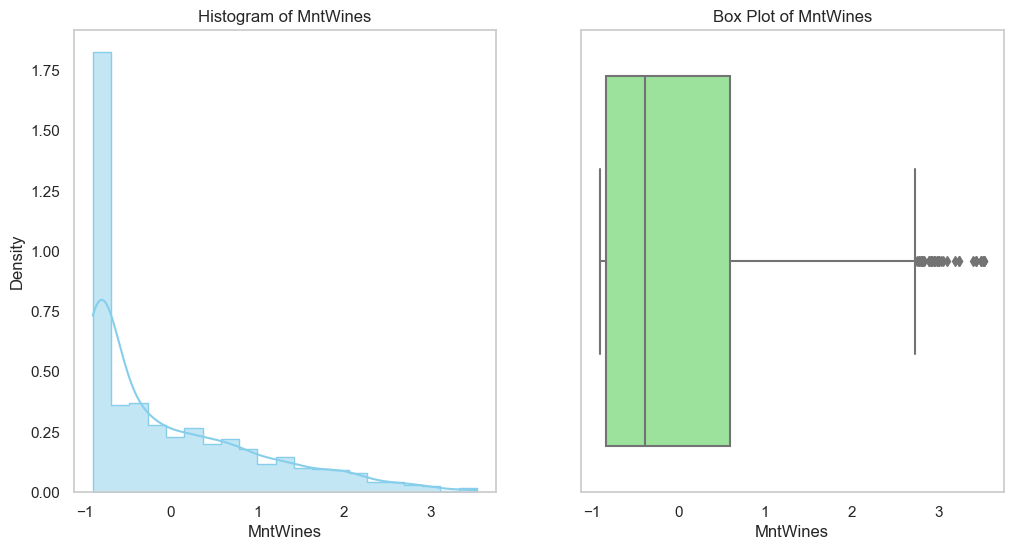

Plotting Histogram for MntMeatProducts
Plotting Box Plot for MntMeatProducts


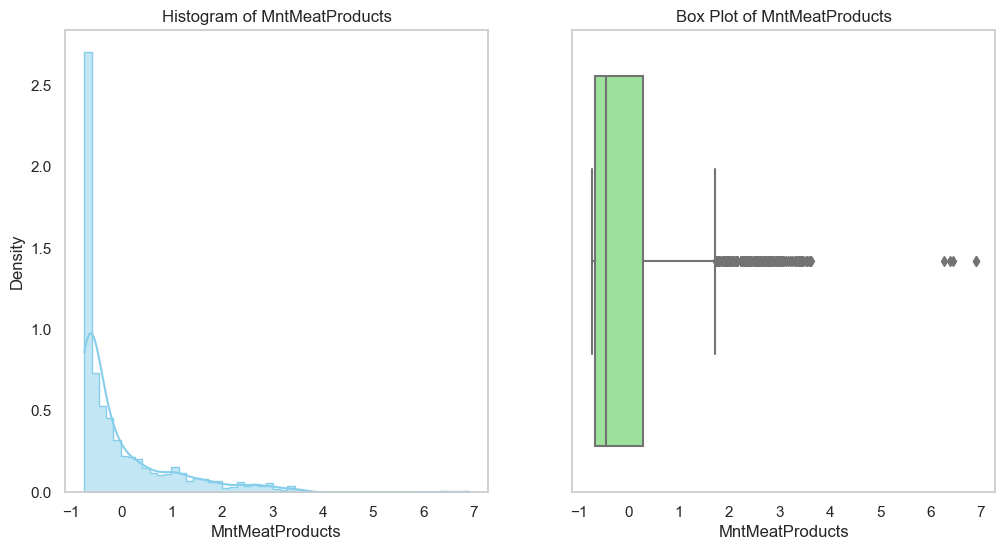

Plotting Histogram for NumCatalogPurchases
Plotting Box Plot for NumCatalogPurchases


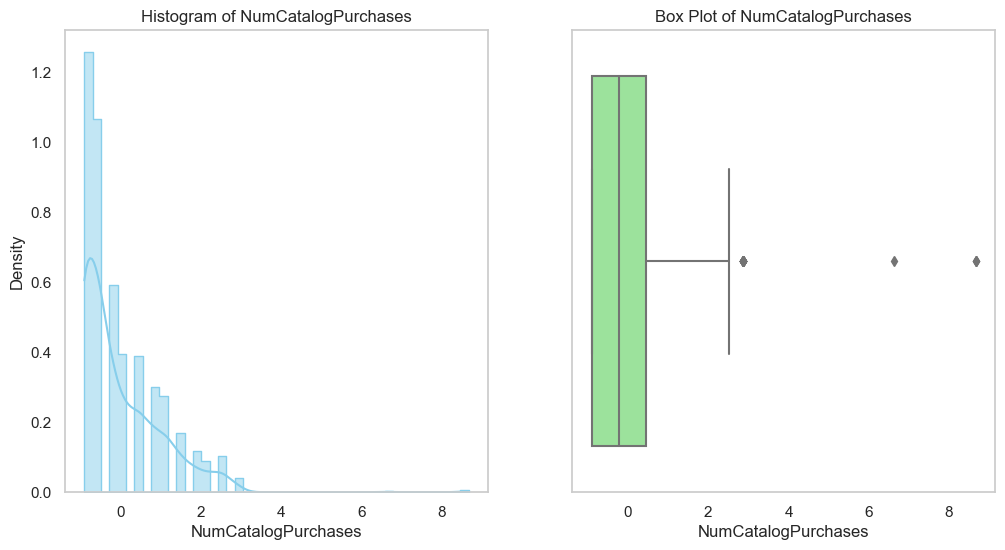

Plotting Histogram for Recency
Plotting Box Plot for Recency


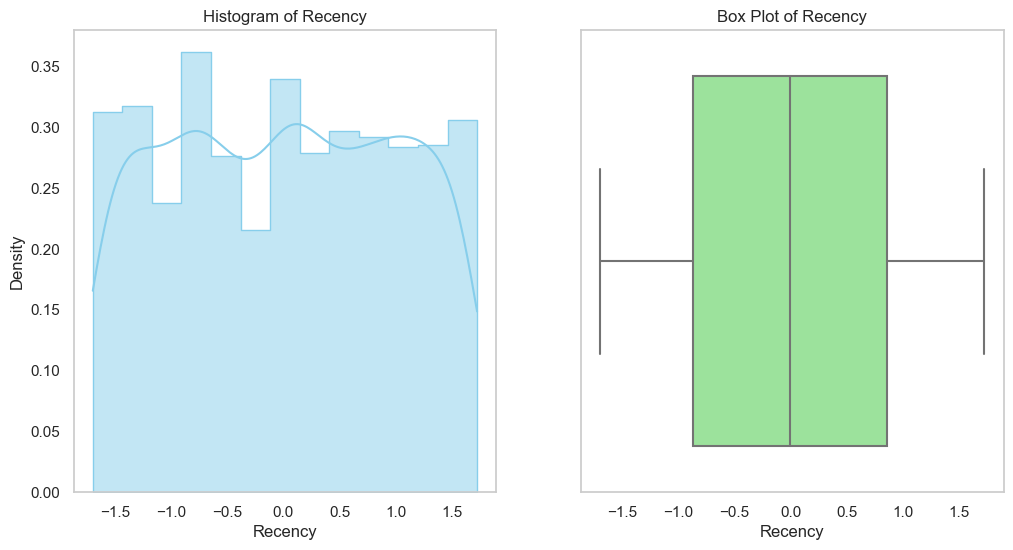

Plotting Histogram for Teenhome
Plotting Box Plot for Teenhome


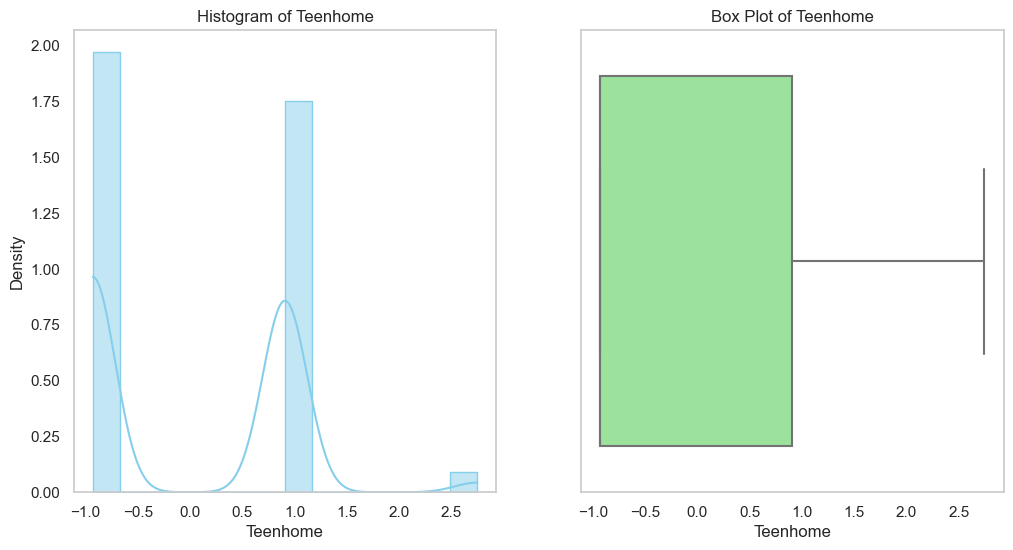


#####################################################################################################

Missing Values per Column:
MntWines               0
MntMeatProducts        0
NumCatalogPurchases    0
Recency                0
Teenhome               0
target                 0
dtype: int64

#####################################################################################################

Number of Unique Values per Column:
MntWines               776
MntMeatProducts        558
NumCatalogPurchases     14
Recency                100
Teenhome                 3
target                   2
dtype: int64

#####################################################################################################

Correlation Matrix of Important Columns:
Plotting Correlation Matrix


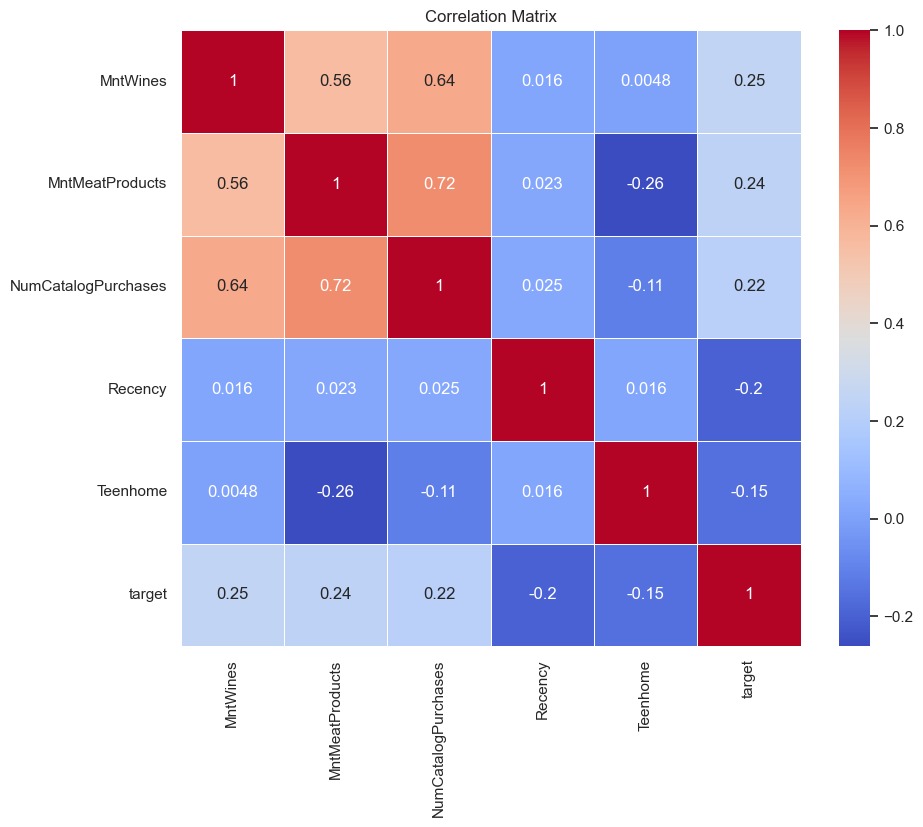


#####################################################################################################

Applying advanced balancing techniques...


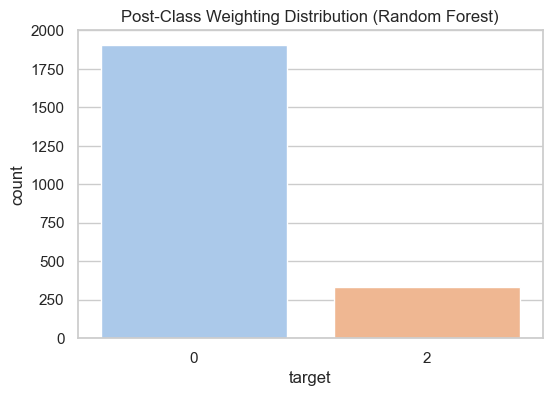

Balanced data saved to: Downloads\balanced_rf_data.csv


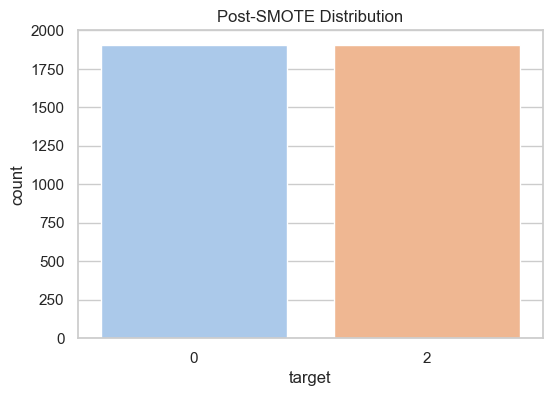

Balanced data saved to: Downloads\balanced_smote_data.csv


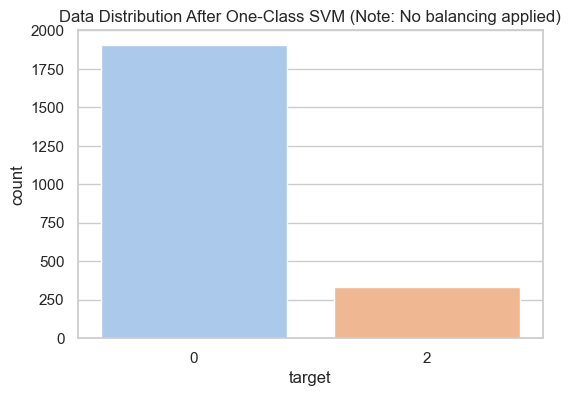

Data saved to: Downloads\svm_data.csv

Processing data balanced by Random Forest...
Applying feature selection...
Reduced feature set size: 10 from original 691
Reduced feature set size: 10 from original 691


PCA applied, explained variance ratio (cumulative): 0.95


Training models for Random Forest balanced data...
Best parameters for Random Forest: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Best parameters for Logistic Regression: {'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'ran


####################################################################################################
Processing complete.


In [32]:
file_path = "superstore_data.csv"  # Specify the actual file path
id_number = None  # Change this to the dataset ID if you have one

# Call the Master function
Master(file_path=file_path, id=id_number)

#### Best Model Selection
Given the requirement to avoid models with accuracy and other scores above 90% to prevent overfitting, the best models are:
#### SMOTE Balanced Data with Logistic Regression:
    Accuracy: 0.74
    F1 Score: 0.74
#### One-Class SVM Balanced Data with Logistic Regression:
    Accuracy: 0.87
    F1 Score: 0.63

### Conclusion
While SMOTE Balanced Data with Logistic Regression and One-Class SVM Balanced Data with Logistic Regression are both viable options, the choice depends on the context:

#### For a better overall balance between metrics without high overfitting risks: 
SMOTE Balanced Data with Logistic Regression is preferred due to its balanced performance metrics.
#### For a more conservative approach with acceptable performance: 
One-Class SVM Balanced Data with Logistic Regression, although with lower F1 score, can be considered due to higher accuracy, ensuring better generalization.